---

# 2. G1 Block Stacking Dataset Finetuning Tutorial

This provides a step-by-step guide on how to finetune GR00T-N1 on the G1 Block Stacking Dataset.

## Step 1: Dataset

Loading any dataset for finetuning can be done in 2 steps:
- 1.1: Defining the modality configs and transforms for the dataset
- 1.2: Loading the dataset using the `LeRobotSingleDataset` class

### Step: 1.0 Download the dataset

- Download the dataset from: https://huggingface.co/datasets/unitreerobotics/G1_BlockStacking_Dataset
- copy over the `examples/unitree_g1_blocks__modality.json` to the dataset `<DATASET_PATH>/meta/modality.json`
  - This provides additional information about the state and action modalities to make it "GR00T-compatible"
  - `cp examples/unitree_g1_blocks__modality.json datasets/G1_BlockStacking_Dataset/meta/modality.json`


**Understanding the Modality Configs**

This file provides detailed metadata about state and action modalities, enabling:

- **Separate Data Storage and Interpretation:**
  - **State and Action:** Stored as concatenated float32 arrays. The `modality.json` file supplies the metadata necessary to interpret these arrays as distinct, fine-grained fields with additional training information.
  - **Video:** Stored as separate files, with the configuration file allowing them to be renamed to a standardized format.
  - **Annotations:** Keeps track of all annotation fields. If there are no annotations, do not include the `annotation` field in the configuration file.
- **Fine-Grained Splitting:** Divides the state and action arrays into more semantically meaningful fields.
- **Clear Mapping:** Explicit mapping of data dimensions.
- **Sophisticated Data Transformations:** Supports field-specific normalization and rotation transformations during training.

#### Schema

```json
{
    "state": {
        "<state_name>": {
            "start": <int>,         // Starting index in the state array
            "end": <int>,           // Ending index in the state array
        }
    },
    "action": {
        "<action_name>": {
            "start": <int>,         // Starting index in the action array
            "end": <int>,           // Ending index in the action array
        }
    },
    "video": {
        "<video_name>": {}  // Empty dictionary to maintain consistency with other modalities
    },
    "annotation": {
        "<annotation_name>": {}  // Empty dictionary to maintain consistency with other modalities
    }
}
```

Example is shown in `getting_started/examples/unitree_g1_blocks__modality.json`. This file is located in the `meta` folder of the lerobot dataset.


Generate the Stats (`meta/metadata.json`) by running the following command:
```bash
python scripts/load_dataset.py --data_path /datasets/G1_BlockStacking_Dataset/ --embodiment_tag new_embodiment
```

In [2]:
from gr00t.data.schema import EmbodimentTag

In [10]:
dataset_path = "D:/Git/Isaac-GR00T/datasets/G1_BlockStacking_Dataset"  # change this to your dataset path
embodiment_tag = EmbodimentTag.NEW_EMBODIMENT

### Step: 1.1 Modality configs and transforms

Modality configs let you select which specific data streams to use for each input type (video, state, action, language, etc.) during finetuning, giving you precise control over which parts of your dataset are utilized.

In [4]:
from gr00t.data.dataset import ModalityConfig


# select the modality keys you want to use for finetuning
video_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["video.cam_right_high"],
)

state_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["state.left_arm", "state.right_arm", "state.left_hand", "state.right_hand"],
)

action_modality = ModalityConfig(
    delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    modality_keys=["action.left_arm", "action.right_arm", "action.left_hand", "action.right_hand"],
)

language_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["annotation.human.task_description"],
)

modality_configs = {
    "video": video_modality,
    "state": state_modality,
    "action": action_modality,
    "language": language_modality,
}

c:\Users\ming_li\miniforge3\envs\env_gr00t\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ming_li\miniforge3\envs\env_gr00t\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
from gr00t.data.transform.base import ComposedModalityTransform
from gr00t.data.transform import VideoToTensor, VideoCrop, VideoResize, VideoColorJitter, VideoToNumpy
from gr00t.data.transform.state_action import StateActionToTensor, StateActionTransform
from gr00t.data.transform.concat import ConcatTransform
from gr00t.model.transforms import GR00TTransform


# select the transforms you want to apply to the data
to_apply_transforms = ComposedModalityTransform(
    transforms=[
        # video transforms
        VideoToTensor(apply_to=video_modality.modality_keys, backend="torchvision"),
        VideoCrop(apply_to=video_modality.modality_keys, scale=0.95, backend="torchvision"),
        VideoResize(apply_to=video_modality.modality_keys, height=224, width=224, interpolation="linear", backend="torchvision" ),
        VideoColorJitter(apply_to=video_modality.modality_keys, brightness=0.3, contrast=0.4, saturation=0.5, hue=0.08, backend="torchvision"),
        VideoToNumpy(apply_to=video_modality.modality_keys),

        # state transforms
        StateActionToTensor(apply_to=state_modality.modality_keys),
        StateActionTransform(apply_to=state_modality.modality_keys, normalization_modes={
            "state.left_arm": "min_max",
            "state.right_arm": "min_max",
            "state.left_hand": "min_max",
            "state.right_hand": "min_max",
        }),

        # action transforms
        StateActionToTensor(apply_to=action_modality.modality_keys),
        StateActionTransform(apply_to=action_modality.modality_keys, normalization_modes={
            "action.right_arm": "min_max",
            "action.left_arm": "min_max",
            "action.right_hand": "min_max",
            "action.left_hand": "min_max",
        }),

        # ConcatTransform
        ConcatTransform(
            video_concat_order=video_modality.modality_keys,
            state_concat_order=state_modality.modality_keys,
            action_concat_order=action_modality.modality_keys,
        ),
        # model-specific transform
        GR00TTransform(
            state_horizon=len(state_modality.delta_indices),
            action_horizon=len(action_modality.delta_indices),
            max_state_dim=64,
            max_action_dim=32,
        ),
    ]
)


### Step 1.2 Load the dataset

First we will visualize the dataset and then load it using the `LeRobotSingleDataset` class. (without transforms)

In [11]:
from gr00t.data.dataset import LeRobotSingleDataset

train_dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=modality_configs,
    embodiment_tag=embodiment_tag,
    video_backend="torchvision_av",
)


Initialized dataset G1_BlockStacking_Dataset with EmbodimentTag.NEW_EMBODIMENT


dict_keys(['video.cam_right_high', 'state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand', 'action.left_arm', 'action.right_arm', 'action.left_hand', 'action.right_hand', 'annotation.human.task_description'])


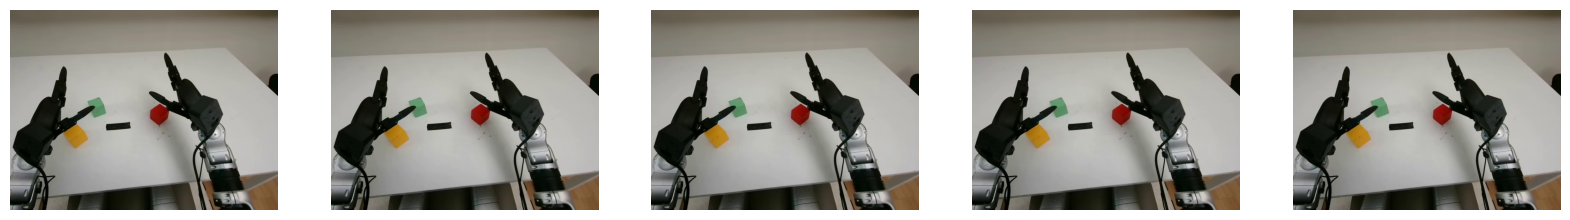

In [12]:
# use matplotlib to visualize the images
import matplotlib.pyplot as plt
import numpy as np

print(train_dataset[0].keys())

images = []
for i in range(5):
    image = train_dataset[i]["video.cam_right_high"][0]
    # image is in HWC format, convert it to CHW format
    image = image.transpose(2, 0, 1)
    images.append(image)   

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, image in enumerate(images):
    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].axis("off")
plt.show()

Now, we will initiate a dataset with our modality configs and transforms.

In [13]:
train_dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=modality_configs,
    embodiment_tag=embodiment_tag,
    video_backend="torchvision_av",
    transforms=to_apply_transforms,
)

Initialized dataset G1_BlockStacking_Dataset with EmbodimentTag.NEW_EMBODIMENT


**Extra Notes**:
 - We use a cached dataloader to accelerate training speed. The cached dataloader loads all data into memory, which significantly improves training performance. However, if your dataset is large or you're experiencing out-of-memory (OOM) errors, you can switch to the standard lerobot dataloader (`gr00t.data.dataset.LeRobotSingleDataset`). It uses the same API as the cached dataloader, so you can switch back and forth without any changes to your code.
 - we use torchvision_av as the video backend, the video encoding is in av instead of standard h264


### Step 2: Load the model

The training process is done in 3 steps:
- 2.1: Load the base model from HuggingFace or a local path
- 2.2: Prepare training args
- 2.3: Run the training loop

#### Step 2.1 Load the base model

We'll use the `from_pretrained_for_tuning` method to load the model. This method allows us to specify which parts of the model to tune.

In [14]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
from gr00t.model.gr00t_n1 import GR00T_N1

BASE_MODEL_PATH = "nvidia/GR00T-N1-2B"
TUNE_LLM = False            # Whether to tune the LLM
TUNE_VISUAL = True          # Whether to tune the visual encoder
TUNE_PROJECTOR = True       # Whether to tune the projector
TUNE_DIFFUSION_MODEL = True # Whether to tune the diffusion model

model = GR00T_N1.from_pretrained(
    pretrained_model_name_or_path=BASE_MODEL_PATH,
    tune_llm=TUNE_LLM,  # backbone's LLM
    tune_visual=TUNE_VISUAL,  # backbone's vision tower
    tune_projector=TUNE_PROJECTOR,  # action head's projector
    tune_diffusion_model=TUNE_DIFFUSION_MODEL,  # action head's DiT
)

# Set the model's compute_dtype to bfloat16
model.compute_dtype = "bfloat16"
model.config.compute_dtype = "bfloat16"
model.to(device)

Loading pretrained dual brain from nvidia/GR00T-N1-2B
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True


Fetching 6 files: 100%|██████████| 6/6 [00:00<?, ?it/s]
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in SiglipVisionModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in LlamaForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 onl

Total number of DiT parameters:  537803776
Tune action head projector: True
Tune action head diffusion model: True


Some weights of the model checkpoint at C:\Users\ming_li\.cache\huggingface\hub\models--nvidia--GR00T-N1-2B\snapshots\32e1fd2507f7739fad443e6b449c8188e0e02fcb were not used when initializing GR00T_N1: ['action_head.decode_layer.bias', 'action_head.decode_layer.weight']
- This IS expected if you are initializing GR00T_N1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GR00T_N1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tune action head projector: True
Tune action head diffusion model: True


GR00T_N1(
  (backbone): EagleBackbone(
    (model): Eagle2ChatModel(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipFlashAttention2(
                  (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
                )
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (m

#### Step 2.2 Prepare training args

We use huggingface `TrainingArguments` to configure the training process. Here are the main parameters:

In [16]:
from transformers import TrainingArguments

output_dir = "D:/Git/Isaac-GR00T/output/"    # CHANGE THIS ACCORDING TO YOUR LOCAL PATH
per_device_train_batch_size = 8     # CHANGE THIS ACCORDING TO YOUR GPU MEMORY
max_steps = 20                      # CHANGE THIS ACCORDING TO YOUR NEEDS
report_to = "wandb"
dataloader_num_workers = 8

training_args = TrainingArguments(
    output_dir=output_dir,
    run_name=None,
    remove_unused_columns=False,
    deepspeed="",
    gradient_checkpointing=False,
    bf16=True,
    tf32=True,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=1,
    dataloader_num_workers=dataloader_num_workers,
    dataloader_pin_memory=False,
    dataloader_persistent_workers=True,
    optim="adamw_torch",
    adam_beta1=0.95,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    learning_rate=1e-4,
    weight_decay=1e-5,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    logging_steps=10.0,
    num_train_epochs=300,
    max_steps=max_steps,
    save_strategy="steps",
    save_steps=500,
    evaluation_strategy="no",
    save_total_limit=8,
    report_to=report_to,
    seed=42,
    do_eval=False,
    ddp_find_unused_parameters=False,
    ddp_bucket_cap_mb=100,
    torch_compile_mode=None,
)


c:\Users\ming_li\miniforge3\envs\env_gr00t\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Step 2.3 Initialize the training runner and run the training loop

In [ ]:
from gr00t.experiment.runner import TrainRunner

experiment = TrainRunner(
    train_dataset=train_dataset,
    model=model,
    training_args=training_args,
)

experiment.train()

Run name: D:/Git/Isaac-GR00T/output/


max_steps is given, it will override any value given in num_train_epochs


train dataloader length: 35150
train dataset length: 281196
GPU memory before training: 8.159651279449463 GB
TensorBoard logs will be saved to: D:\Git\Isaac-GR00T\output\runs


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: deming08 (deming08-asus). Use `wandb login --relogin` to force relogin


  0%|          | 0/20 [00:00<?, ?it/s]The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
 25%|██▌       | 5/20 [08:38<18:40, 74.73s/it]   

We can see the 1k offline validation results vs 10k offline validation results:

**Finetuning Results on Unitree G1 Block Stacking Dataset:**

| 1k Steps | 10k Steps |
| --- | --- |
| ![1k](../media/g1_ft_1k.png) | ![10k](../media/g1_ft_10k.png) |
| MSE: 0.0181 | MSE: 0.0022 |